## Sagnac Frequency - Drift Analysis

### Import Libraries

In [26]:
%autosave 120

import os
import yaml
import matplotlib.pyplot as plt

from pandas import read_csv, DataFrame, date_range
from obspy import UTCDateTime, read, Stream
from numpy import nanmean, zeros, ones, nanmedian

from andbro__readYaml import __readYaml
from andbro__savefig import __savefig

from andbro__querrySeismoData import __querrySeismoData

Autosaving every 120 seconds


In [2]:
if os.uname().nodename == "lighthouse":
    root_path = "/home/andbro/"
    data_path = "/home/andbro/kilauea-data/"
    archive_path = "/home/andbro/freenas/"
elif os.uname().nodename == "kilauea":
    root_path = "/home/brotzer/"
    data_path = "/import/kilauea-data/"
    archive_path = "/import/freenas-ffb-01-data/"

### Define Functions

In [3]:
def __smooth(y, box_pts):
    from numpy import ones, convolve, hanning

#     win = ones(box_pts)/box_pts
    win = hanning(box_pts)
    y_smooth = convolve(y, win/sum(win), mode='same')

    return y_smooth

## Configurations

In [4]:
## configurations
config={}

config['save'] = False

## get 'raw' data from romy archive
# config['datapath'] = f"{archive_path}/romy_archive"

## get downsampled data 
config['datapath'] = f"{data_path}TiltmeterDataBackup/Tilt_downsampled"

## time selection
config['tbeg'] = UTCDateTime("2022-01-01 00:00")
config['tend'] = UTCDateTime("2022-06-12 00:00")

## specify output directory for figures
config['output_figures'] = f"{root_path}Documents/ROMY/tiltmeter/figures/"

## indicate path to wromy data
config['path_to_furt'] = f"{data_path}wromy/"
config['path_to_wromy'] = f"{archive_path}romy_archive/2022/BW/WROMY/"


config['path_to_tilt'] = f"{root_path}notebooks/Tilt/"

config['path_to_sagnac'] = f"{data_path}sagnac_frequency/hilbert_60_RZ/"

## Load Data

### Load ROMY Saganac Frequency

In [5]:
def __load_beat(config, path_to_data):
    
    from datetime import date
    from pandas import read_pickle, concat

    t1 = date.fromisoformat(str(config['tbeg'].date))
    t2 = date.fromisoformat(str(config['tend'].date))

    df = DataFrame()
    for dat in date_range(t1,t2):
        file = str(dat)[:10].replace("-","")+".pkl"
        try:
            df0 = read_pickle(path_to_data+file)
            df = concat([df, df0])
        except:
            print(f"error for {file}")
            
    return df

In [6]:
df1 = __load_beat(config, config['path_to_sagnac'])
     
from numpy import where, nan, array
from obspy import Trace
# df1['freqs'] = where(df1['psd_max'] > 1e5, df1['freqs'], nan)

beat = Trace()
beat.data = array(df1['freqs'])
beat.stats.starttime = config['tbeg']
beat.stats.sampling_rate = 1/60


### Load Tiltmeter Data

In [7]:
tilt = read(f"{config['path_to_tilt']}tilt_all_Tcorrect.mseed")

tilt.trim(config['tbeg'], config['tend'])

for tr in tilt:
    tr.data -= nanmean(tr.data[:50])

9 Trace(s) in Stream:
BW.TROMY..MAN | 2021-12-31T23:59:59.955000Z - 2022-06-11T23:59:59.955000Z | 600.0 s, 23329 samples
BW.TROMY..MAT | 2021-12-31T23:59:59.955000Z - 2022-06-11T23:59:59.955000Z | 600.0 s, 23329 samples
BW.TROMY..MAE | 2021-12-31T23:59:59.955000Z - 2022-06-11T23:59:59.955000Z | 600.0 s, 23329 samples
BW.ROMYT..MAE | 2022-04-12T15:44:07.140000Z - 2022-06-12T00:04:07.140000Z | 600.0 s, 8691 samples
BW.ROMYT..MAN | 2022-04-12T15:44:07.140000Z - 2022-06-12T00:04:07.140000Z | 600.0 s, 8691 samples
BW.ROMYT..MAT | 2022-04-12T15:44:07.140000Z - 2022-06-12T00:04:07.140000Z | 600.0 s, 8691 samples
BW.DROMY..LAE | 2022-01-01T00:00:00.000000Z - 2022-05-31T23:50:00.000000Z | 600.0 s, 21744 samples
BW.DROMY..LAN | 2022-01-01T00:00:00.000000Z - 2022-05-31T23:50:00.000000Z | 600.0 s, 21744 samples
BW.DROMY..LAT | 2022-01-01T00:00:00.000000Z - 2022-05-31T23:50:00.000000Z | 600.0 s, 21744 samples

### Load WROMY and FURT

In [8]:
from andbro__load_FURT_stream import __load_furt_stream

In [9]:
furt = __load_furt_stream(config)

  0%|          | 0/163 [00:00<?, ?it/s]

/home/brotzer/anaconda3/lib/python3.7/site-packages/andbro__load_FURT_stream.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['datetime'] = to_datetime(df['datetime'], format="%d%m%y %H%M%S", errors="coerce")


Specified end: 2022-06-12T00:00:00.000000Z 
Trace end:     2022-06-12T00:00:00.000000Z


In [13]:
def __load_furt_data(path_to_wromy, channel):
    
    from os import listdir
    from tqdm.notebook import tqdm
    from pandas import read_pickle, concat
    
    files = listdir(path_to_wromy+channel)
    
    for n, file in enumerate(tqdm(files)):
        df0 = read_pickle(path_to_wromy+channel+"/"+file)
        if n == 0:
            df_raw = df0
        else: 
            df_raw = concat([df_raw,df0])
    df_raw.reset_index()
    return df_raw

In [14]:
def __cumsum_rain(arr, xnum):
    
    from numpy import cumsum, zeros
    
    arr_out = zeros(len(arr))
    for i, dat in enumerate(arr):
        arr_out[i] = sum(arr[i:i+xnum])
    
    return arr_out

In [35]:
FURT_raw = __load_furt_data(config['path_to_furt'], "FURT") 
furt = FURT_raw.copy()
furt.dropna(inplace=True)
furt.sort_values('TimeStamp', inplace=True)
furt.reset_index(drop=True, inplace=True)

  0%|          | 0/363 [00:00<?, ?it/s]

In [36]:
num = 5  ## in days

rain_data = __cumsum_rain(furt.Rc, int(1440*num/10))

rain = Trace()
rain.data = array(rain_data)
rain.stats.starttime = furt['TimeStamp'][0]
rain.stats.sampling_rate = 1/600
rain.trim(config['tbeg'], config['tend'])

... | 2022-01-01T00:00:00.000000Z - 2022-06-12T00:00:00.000000Z | 600.0 s, 23329 samples

In [41]:
from andbro__load_WROMY_stream import __load_wromy_stream

ws1 = __load_wromy_stream(config, config['path_to_wromy'], "BW.WROMY..WS1")
ws5 = __load_wromy_stream(config, config['path_to_wromy'], "BW.WROMY..WS5")
ws9 = __load_wromy_stream(config, config['path_to_wromy'], "BW.WROMY..WS9")

  0%|          | 0/164 [00:00<?, ?it/s]

Specified end: 2022-06-12T00:00:00.000000Z 
Trace end:     2022-06-12T00:00:00.000000Z


## Processing

In [22]:
## create copy of beat note
beat_smooth = beat.copy()

## exclude values outside interval for beat note
beat_lower, beat_upper = 553.35, 553.42

beat_data = zeros(len(beat_smooth.data))

for i, dat in enumerate(beat_smooth.data):
    if dat >= beat_lower and dat <= beat_upper:
        beat_data[i] = dat
    else:
        beat_data[i] = nan

## smoothing time seriese of beat note
beat_smooth.data = __smooth(beat_data, 180)
beat_smooth.data[:180] = nan*ones(180)

### Express as change of triangle height

In [23]:
def __to_H(data):
    
    from numpy import cos, pi, deg2rad, sqrt, nanmedian
    
    H = data * 3/2 * 632.8e-9 / (2*pi/86400 * cos(deg2rad(48.162941)))
    
#     H_expected = 2*53.93/11.3
    H_expected = 11.3/2*sqrt(3)
    
#     H_rel = abs(H-H_expected)/H_expected 
    H_rel = abs(H-H_expected) 
    H_rel = H - nanmedian(H)
    
    return H, H_rel

In [24]:
data = beat_smooth.trim(config['tbeg'], config['tend']).data

H, H_rel = __to_H(data)

median:  18.5705467657  e-6/°C
mean:    592.312260415  e-6/°C


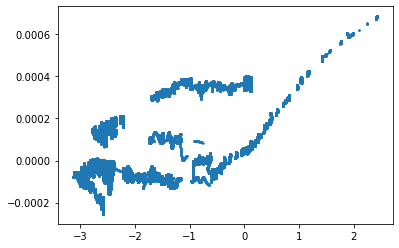

In [27]:
temp = tilt.copy().select(station="TROMY", channel="*T")[0].resample(1/60).trim(config['tbeg'], config['tend']).data
# temp -= nanmean(temp[:20])

dx = 100
plt.scatter(temp[dx:-dx], H_rel[dx:-dx], s=1)

print("median: ", nanmedian(H_rel/temp*1e6), " e-6/°C")
print("mean:   ",nanmean(H_rel/temp*1e6), " e-6/°C")

### Express as tilt variation

In [38]:
def __to_tilt(data):
    
    from numpy import pi, sqrt, arccos, deg2rad
    
    return -1 * (arccos((data * 632.8e-9 * 3) / ( (2*pi/86400) * 11.3 * sqrt(3) )) + deg2rad(48.162941))

In [39]:
beat_tilt = __to_tilt(beat_smooth.data)

beat_tilt -= nanmedian(beat_tilt[:500])

## Plotting

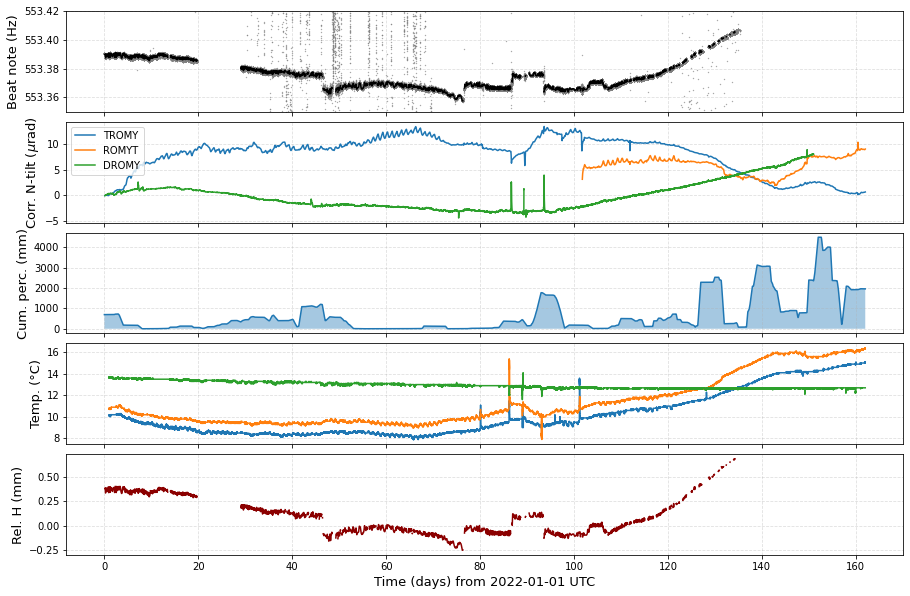

In [49]:
def __makeplot(config):
    
    from numpy import zeros
    
    smooth = 180
    
    time_reference = "2022-01-01"
    
    N = 5
    
    time_scaling, time_unit = 1/86400, "days"
    time_reference = "2022-01-01"
    
    font = 13
    
    fig, ax = plt.subplots(N, 1, figsize=(15,10), sharex=True)
    
    plt.subplots_adjust(hspace=0.1)
    
    
    
    ## exclude values outside interval for beat note
    beat_lower, beat_upper = 553.35, 553.42
    
    beat_data = zeros(len(beat.data))

    for i, dat in enumerate(beat.data):
        if dat >= beat_lower and dat <= beat_upper:
            beat_data[i] = dat
        else:
            beat_data[i] = nan
    

    ## ----------------------
    
    ## PANEL 0 ---------    
    ax[0].scatter(beat.times(reftime=UTCDateTime(time_reference))*time_scaling, beat_data, s=0.1, color='grey')
    ax[0].plot(beat.times(reftime=UTCDateTime(time_reference))[smooth:]*time_scaling, __smooth(beat_data, smooth)[smooth:], 'k')
    
    ## PANEL 1 ---------
    for tr in tilt.select(channel="*N"):
        ax[1].plot(tr.times(reftime=UTCDateTime(time_reference))[15:]*time_scaling, tr.data[15:]*1e6, label=tr.stats.station)

#     ax[1].plot(beat_smooth.times(reftime=UTCDateTime(time_reference))[smooth:]*time_scaling, beat_tilt[smooth:]*1e6)

    ## PANEL 2 ---------
    ax[2].plot(rain.times()*time_scaling, rain.data)
    ax[2].fill_between(rain.times(reftime=UTCDateTime(time_reference))*time_scaling, 0, rain.data, alpha=0.4)
    
    ## PANEL 3 ---------
    ws5_timeaxis = ws5.select(channel="*T")[0].times(reftime=UTCDateTime(time_reference))*time_scaling
    ax[3].plot(ws5_timeaxis, ws5.select(channel="*T")[0].data, label="WS5 T")
    
    ws9_timeaxis = ws9.select(channel="*T")[0].times(reftime=UTCDateTime(time_reference))*time_scaling
    ax[3].plot(ws9_timeaxis, ws9.select(channel="*T")[0].data, label="WS9 T")
    
    ws1_timeaxis = ws1.select(channel="*T")[0].times(reftime=UTCDateTime(time_reference))*time_scaling
    ax[3].plot(ws1_timeaxis, ws1.select(channel="*T")[0].data, label="WS1 T")

    ## PANEL 4 ---------
    ax[4].plot(beat_smooth.times(reftime=UTCDateTime(time_reference))[smooth:]*time_scaling, H_rel[smooth:]*1e3, color="darkred")
        

        
    ## ----------------------
        
    for axx in ax:
        axx.grid(ls="--", alpha=0.4)
    
#     ax[0].set_ylim(553.35,553.42)
    ax[0].set_ylim(beat_lower, beat_upper)

    ax[0].set_ylabel(f"Beat note (Hz)", fontsize=font)
    ax[1].set_ylabel(f"Corr. N-tilt ($\mu$rad)", fontsize=font)
    ax[2].set_ylabel(f"Cum. perc. (mm)", fontsize=font)
    ax[3].set_ylabel(f"Temp. (°C)", fontsize=font)
    ax[4].set_ylabel(f"Rel. H (mm)", fontsize=font)
    
    ax[N-1].set_xlabel(f"Time (days) from {time_reference} UTC", fontsize=font)
    ax[1].legend()
    
    plt.show();
    return fig

__makeplot(config);

In [ ]:
t1 = UTCDateTime("2022-04-26")
t2 = UTCDateTime("2022-05-20")

temp = TROMY.copy().select(channel="*T")[0].resample(1/60).trim(t1, t2).data
temp -= nanmean(temp[:20])

H = __to_H(beat.data)

H_expected = 2*53.93/11.3

H_rel = abs(H-H[0])/H_expected 

plt.scatter(temp, H_rel)

print(np.nanmedian(H_rel/temp), " /°C")

In [ ]:
# __savefig(fig, outpath=config['output_figures'], outname="Tilt_ALL_EarthTides_TempCorrect_TheoResiduals_BeatNote", mode="png", dpi=None)

In [ ]:
# import numpy as np
# w1 = np.arcsin(np.deg2rad(553.375 * 33.6 * 632.8e-9 / 4 / 53.93 / (2*np.pi/86400)))

# w2 = np.arcsin(np.deg2rad(553.41 * 33.6 * 632.8e-9 / 4 / 53.93 / (2*np.pi/86400)))

# abs(w1-w2)*1e6

## Compare with Ambient Air Pressure

In [ ]:
from numpy import nan
BROMY 
# BROMY = BROMY.split().merge(fill_value=nan)
BROMY = BROMY.split().merge(fill_value="interpolate")
BROMY

In [ ]:
def __load_wromy_data(channel, config):
    
    from os import listdir
    from tqdm.notebook import tqdm
    from pandas import read_pickle, concat

    files = listdir(config['path_to_wromy']+channel)
    
    for n, file in enumerate(tqdm(files)):
        df0 = read_pickle(config['path_to_wromy']+channel+"/"+file)
        if n == 0:
            df_raw = df0
        else: 
            df_raw = concat([df_raw,df0])
    df_raw.reset_index()
    return df_raw

In [ ]:
def __add_wromy_trace(stream, ws):

    from numpy import array

    df0 = __load_wromy_data(ws, config)
    df0.dropna(inplace=True)
    df0.sort_values('TimeStamp', inplace=True)
    df0.reset_index(drop=True, inplace=True)
    wsx = df0

    ## limit to tbeg - tend
    times_absolut = stream.select(channel="*T")[0].times(reftime=UTCDateTime("2019-01-01T00"))
    wsx = wsx[(wsx['totalSeconds'] >= times_absolut[0]) & (wsx['totalSeconds'] <= times_absolut[-1]+500)]

    if len(wsx['totalSeconds']) != stream[0].stats.npts:
        print(f"-> npts don't match: {len(wsx['totalSeconds'])} != {stream[0].stats.npts}")
    
    ## create trace and addto stream
    tr_wsx = stream.select(channel="*T")[0].copy()
    tr_wsx.data = array(wsx['Pressure (hPa)'])
    tr_wsx.stats.channel = ws
    stream += tr_wsx

In [ ]:
__add_wromy_trace(ROMYT, "WS9")
__add_wromy_trace(TROMY, "WS5")
__add_wromy_trace(BROMY, "WS1")

In [ ]:
def __makeplotStreamPSD(config, st, st2=None):

    from scipy import fftpack
    from numpy import log10, median
    from scipy.signal import welch, periodogram, hann

    
    nblock =  1028
    overlap = None
    win = hann(nblock, True)

    NN = len(st)
    
    fig, axes = plt.subplots(NN,2,figsize=(15,15), sharex='col')

    plt.subplots_adjust(hspace=0.3)

    ## _______________________________________________

    st.sort(keys=['station','channel'], reverse=True)
    
    for i, tr in enumerate(st):

#         ff, Pxx = welch(tr.data, 
#                         fs=tr.stats.sampling_rate, 
#                         window=win, 
#                         noverlap=overlap, 
#                         nfft=nblock,
#                         scaling="density",
#                         return_onesided=True,
#                        )
        ff, Pxx = periodogram(tr.data, 
                              fs=tr.stats.sampling_rate, 
                              window=None,
                              scaling="density",
                              return_onesided=True,
                             )
        
        if st2 is not None:
            ff2, Pxx2 = welch(st2[i].data, 
                              fs=st2[i].stats.sampling_rate, 
                              window=win,
                              noverlap=overlap, 
                              nfft=nblock,
                              scaling="density", 
                              return_onesided=True,
                             )
        
        ## _________________________________________________________________
        axes[i,0].plot(
                    tr.times()/86400,
                    tr.data*1e6,
                    color='black',
                    label='{} {}'.format(tr.stats.station, tr.stats.channel),
                    lw=1.0,
                    )


        ## _________________________________________________________________
#         axes[i,1].loglog(ff, Pxx, color='black', lw=1.0,)
        axes[i,1].semilogx(ff, Pxx, color='black', lw=1.0,)
        
        if st2 is not None:
#             axes[i,1].loglog(ff2, Pxx2, color='red', lw=1.0,)       
            axes[i,1].semilogx(ff2, Pxx2, color='red', lw=1.0,)       
        
        
        axes[i,1].vlines(1/86400,min(Pxx[:]), max(Pxx[:]), color="darkgrey", alpha=1.0, zorder=0)
        axes[i,1].vlines(2/86400,min(Pxx[:]), max(Pxx[:]), color="darkgrey", alpha=1.0, zorder=0)
        
        axes[NN-1,0].set_xlabel("Time (days)")
        axes[NN-1,1].set_xlabel("Frequency (Hz)")
        
        axes[i,1].set_ylim(min(Pxx[:]), max(Pxx[:]))
        
        axes[i,0].set_ylabel(r'Tilt ($\mu$rad)')    
        axes[i,1].set_ylabel(r'PSD (rad$^2$/Hz)')        
        axes[i,0].legend(loc='upper left',bbox_to_anchor=(0.8, 1.10), framealpha=1.0)
        
#         axes[i,0].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
        axes[i,1].ticklabel_format(axis='y', style='sci', scilimits=(0,0))

#         axes[i,1].set_xlim(3e-6,1e-4)
        axes[i,1].set_xlim(1e-5,5e-5)
        
#         axes[0,1].set_ylim(0, 2e6)
#         axes[3,1].set_ylim(0, 2e6)
#         axes[6,1].set_ylim(0, 2e6)
        
#         axes[1,1].set_ylim(0, 5e-9)
#         axes[2,1].set_ylim(0, 5e-8)
#         axes[4,1].set_ylim(0, 3e-8)
#         axes[5,1].set_ylim(0, 1e-8)
#         axes[7,1].set_ylim(0, 9e-8)
#         axes[8,1].set_ylim(0, 9e-8)

        axes[0,1].set_ylim(0, .5e6)        
        axes[1,1].set_ylim(0, 3e-9)
        axes[2,1].set_ylim(0, 4e-8)
        axes[3,1].set_ylim(0, .5e6)
        axes[4,1].set_ylim(0, 1.5e-8)
        axes[5,1].set_ylim(0, 1e-8)
        axes[6,1].set_ylim(0, .5e6)
        axes[7,1].set_ylim(0, 9e-8)
        axes[8,1].set_ylim(0, 9e-8)
        
        axes[0,0].set_ylabel(r'Pressure (hPa)') 
        axes[3,0].set_ylabel(r'Pressure (hPa)') 
        axes[6,0].set_ylabel(r'Pressure (hPa)') 
        
        plt.suptitle(r"Highpass: 10 $mu$Hz", y=0.92, fontsize=14)
        
    return fig

In [ ]:
# fig = __makeplotStreamPSD(config, st_f, st2=None);

In [ ]:
def __makeplotStreamSpectra(st, config):

    from scipy import fftpack
    from numpy import abs

    NN = len(st)

    fig, axes = plt.subplots(NN,2,figsize=(15,10), sharex='col')

    plt.subplots_adjust(hspace=0.3)

    ## _______________________________________________

    st.sort(keys=['channel'], reverse=True)
    
    for i, tr in enumerate(st):

        comp_fft = abs(fftpack.fft(tr.data))
        ff       = fftpack.fftfreq(comp_fft.size, d=1/tr.stats.sampling_rate)
        comp_fft = fftpack.fftshift(comp_fft)


        ## _________________________________________________________________
        axes[i,0].plot(
                    tr.times()/86400,
                    tr.data*1e6,
                    color='black',
                    label='{} {}'.format(tr.stats.station, tr.stats.channel),
                    lw=1.0,
                    )


        ## _________________________________________________________________
        fxx = abs(fftpack.fft(tr.data)[1:len(ff)//2])
        axes[i,1].loglog(
                    ff[1:len(ff)//2],
                    fxx,
                    color='black',
                    lw=1.0,
                    )
        
        axes[i,1].vlines(1/86400,min(fxx[:]), max(fxx[:]), color="darkgrey", alpha=1.0, zorder=0)
        axes[i,1].vlines(2/86400,min(fxx[:]), max(fxx[:]), color="darkgrey", alpha=1.0, zorder=0)
        
        axes[NN-1,0].set_xlabel("Time (days)")
        axes[NN-1,1].set_xlabel("Frequency (Hz)")
                      
        axes[i,0].set_ylabel(r'$\Omega$ ($\mu$rad)')    
        axes[i,1].set_ylabel(r'ASD (rad/Hz)')        
        axes[i,0].legend(loc='upper left',bbox_to_anchor=(0.8, 1.10), framealpha=1.0)
#         axes[i,0].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
#         axes[i,1].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
#         axes[i,1].set_xlim(1e-7,0.25)
#         axes[i,1].set_ylim(1e-12,1e-9)

    return fig

In [ ]:
# fig = __makeplotStreamSpectra(st_all, config);